### Training Clock Validation Models

This file mainly prepars models which can identify regoins in a clock dataset where a fail state occured in time of TempCo testing.

#### Imports

In [1]:
# PyTorch
import torch, os
import torch.optim as optim
from torch.utils.data import DataLoader


# Custom functions and classes
from dataHandler import ClockDataset
from classifiers import PtClassifier_V2

device = "cuda" if torch.cuda.is_available() else "cpu"

#### Prepare Clock Dataset

TempCo data: clock data collected during clock testing undergoing temperature cycling over the course of a set period of time.

In [2]:
# Paths containing testing and training datasets
TEST_DATASET  = os.path.join(os.getcwd(), r"data\test")
TRAIN_DATASET = os.path.join(os.getcwd(), r"data\train")
BATCH_SIZE = 1

# Creating Datasets
clock_dataset_test = ClockDataset(f_data=TEST_DATASET)
clock_dataset_train = ClockDataset(f_data=TRAIN_DATASET)

# Creating Dataloaders
train_dataloader = DataLoader(
    dataset=clock_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3)

test_dataloader = DataLoader(
    dataset=clock_dataset_test,
    drop_last=True,
    batch_size=BATCH_SIZE,
    num_workers=3)

print(f"Number of clocks in train dataset: {clock_dataset_train.__len__()}")
print(f"Number of clocks in test dataset: {clock_dataset_test.__len__()}")

Number of clocks in train dataset: 27
Number of clocks in test dataset: 18


In [3]:
# Sample data
sample_param, sample_labels, sample_columns, sample_validation = next(iter(train_dataloader))

print(f"Sample Parameter row:\n{sample_param[0][0]}")
print(f"Sample Label: {sample_labels[0]}")
print(f"Sample Columns: {sample_columns}")
print(f"Sample Validation: {sample_validation[0]}")

print(f"Length of sample parameters: {len(sample_param[0])}")

Sample Parameter row:
tensor([1.1717e+00, 3.3313e+04, 1.4602e+04, 9.1960e+03, 5.4060e+03, 1.3960e+00,
        3.5456e+04, 3.2528e+04, 3.3688e+01, 8.4958e+01, 8.3980e+01, 4.1279e+04,
        3.9722e+04, 2.6685e+04, 6.1000e+02])
Sample Label: tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])
Sample Columns: [('DCL',), ('PDADC',), ('CPTP',), ('CPTF',), ('CPTD',), ('VBC',), ('VFA',), ('XFA',), ('TPCB',), ('VTEMP',), ('CTEMP',), ('VHTR',), ('CHTR',), ('RFL',), ('PDSU',), ('FAIL',)]
Sample Validation: fail_passedLater
Length of sample parameters: 167758


Testing batch dimmensions on a clock dataset.

NOTE: Batch dimmensions in the clock dataloader have dim issues that still need to be sorted out.

In [4]:
clock_data = sample_param[0]

# Create a batch_size of 64
batches = []
for row in range(0, len(clock_data), 64):
    batch = clock_data[row:row+8]
    batches.append(batch)

print(len(batches))

2622


#### Import Model

In [5]:
NUM_PARAMS  = clock_dataset_train[0][0][0].__len__()
NUM_CLASSES = clock_dataset_train[0][1][0].__len__()
model = PtClassifier_V2(parameters=NUM_PARAMS, classes=NUM_CLASSES)
model = model.to(device)
print(f"Number of parameters for model input: {NUM_PARAMS}")
print(f"Number of classes: {NUM_CLASSES}")

Number of parameters for model input: 15
Number of classes: 1


#### Optimizer and Loss Function

In [6]:
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

#### Training
Note:
    Models take a long time to train ~6 min per clock.
    This is because we are trainning the models on each second of data per clockk.
    Training time can be improved by reducing the datasets by factoring out:
        - Data where clock is idle 
        - Introduce a batch parameter when training per clock to train on batches of seconds   

In [7]:
from engine import train_batch
NUM_EPOCHS = 1

trn_l, trn_a, tst_l, tst_a = train_batch(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    optimizer=optimizer,
    loss_fn=criterion,
    batch_size=128,
    device=device,
    epochs=NUM_EPOCHS
)
print(trn_l)
print(trn_a)

''' 
    Implement batch size per training and testing step per clock to reduce training time.
'''

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
Training Clock | 0
Training Clock | 1
Training Clock | 2
Training Clock | 3
Training Clock | 4
Training Clock | 5
Training Clock | 6
Training Clock | 7
Training Clock | 8
Training Clock | 9
Training Clock | 10
Training Clock | 11
Training Clock | 12
Training Clock | 13
Training Clock | 14
Training Clock | 15
Training Clock | 16
Training Clock | 17
Training Clock | 18
Training Clock | 19
Training Clock | 20
Training Clock | 21
Training Clock | 22
Training Clock | 23
Training Clock | 24
Training Clock | 25
Training Clock | 26
Testing Clock: 0 | fail
Testing Clock: 1 | fail
Testing Clock: 2 | fail
Testing Clock: 3 | fail
Testing Clock: 4 | fail_passedLater
Testing Clock: 5 | fail_passedLater
Testing Clock: 6 | fail_passedLater
Testing Clock: 7 | fail_passedLater
Testing Clock: 8 | pass
Testing Clock: 9 | pass
Testing Clock: 10 | pass
Testing Clock: 11 | pass
Testing Clock: 12 | pass
Testing Clock: 13 | pass
Testing Clock: 14 | pass
Testing Clock: 15 | pass
Testing Clock: 16 | pas

' \n    Implement batch size per training and testing step per clock to reduce training time.\n'

Saving the model

In [8]:
model.save(os.path.join(os.getcwd()), 1)

Model saved to: d:\Repos\Spyder\CSAC\src/models/csac_ml_1.pth


In [9]:
model  = torch.load('d:\Repos\Spyder\CSAC\src/models/csac_ml_1.pth')

# Sample data
sample_param, sample_labels, sample_columns, sample_validation = next(iter(train_dataloader))
t = sample_param[0].to(device)
test_labels = model(t)
y_preds_batch_train = torch.round(torch.sigmoid(test_labels)).to(torch.int64)

accuracy = torch.sum(torch.eq(y_preds_batch_train, sample_labels[0].to(device))).item()

print(f"Accuracy: {accuracy/len(sample_labels[0])}")

print(y_preds_batch_train)
print(sample_labels[0])

C:\Users\btehrani\AppData\Local\Temp\ipykernel_102196\1869267043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model  = torch.load('d:\Repos\Spyder\CSAC\src/models/csa

Accuracy: 0.42710927770859275
tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]])


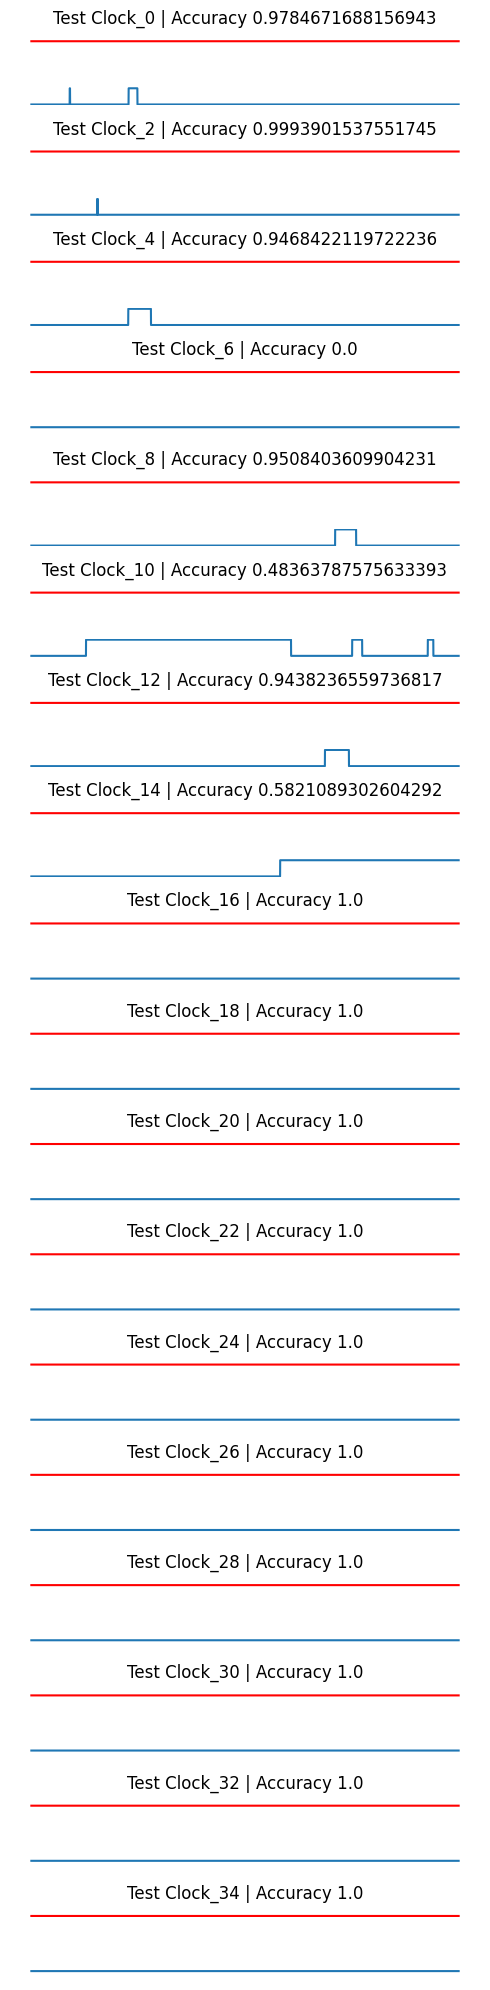

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2*clock_dataset_test.__len__(), ncols=1, figsize=(5, 20))
i=0
for clock_data, labels, _, validation in test_dataloader:
    preds = model(clock_data[0].to(device))
    pred_labels = torch.round(torch.sigmoid(preds)).to(torch.int64)
    acc = torch.sum(torch.eq(pred_labels, labels[0].to(device))).item()

    ax[i].plot(pred_labels.cpu(), c='r')
    ax[i].axis("off")
    ax[i].set_title(f'Test Clock_{i} | Accuracy {acc/len(labels[0])}')
    ax[i+1].plot(labels[0])
    ax[i+1].axis("off")
    i = i+2
plt.tight_layout()


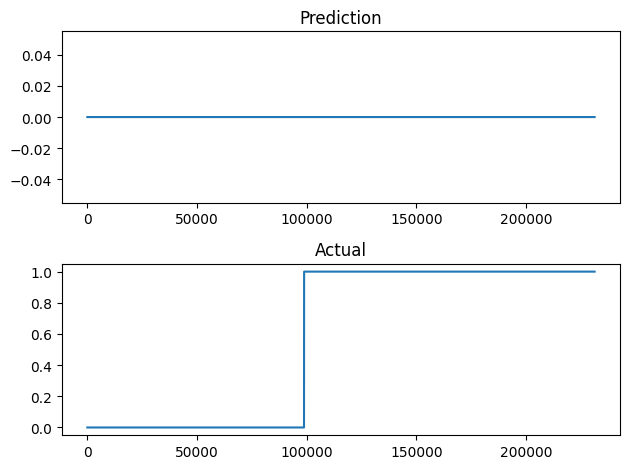

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(y_preds_batch_train.cpu())
ax[0].set_title("Prediction")

ax[1].plot(sample_labels[0])
ax[1].set_title("Actual")
plt.tight_layout()

